# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler 
#TSNE
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Temporarily Suppressing Warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# [1]. Reading Data

In [3]:
# using the SQLite Table to read data.
# con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')

con = sqlite3.connect('C:/Users/Saraswathi/Music/Appliedai/Data/amazon-fine-food-reviews/database.sqlite')

#filetering only positve and negative reviews
#reviews not taking in to consideration with score = 3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition( x ):
    if x > 3:
        return 1 #positive
#         return 1
    else:
        return 0 #negative

#changing reviews with score less than 3 to be positive and vice versa
actual_score = filtered_data['Score']
positivenegative = actual_score.map(partition)
filtered_data['Score']=positivenegative
print('Number of data point in our data',filtered_data.shape)
filtered_data.head(5)    

Number of data point in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""",con)

In [5]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending= True, inplace=False, kind ='quicksort',na_position='last')

In [7]:
#Duplication of entries
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep = 'first' , inplace= False)
final.shape

(87775, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions
    

In [9]:
display = pd.read_sql_query("""
SELECt * 
FROM Reviews
WHERE Score !=3 AND Id=44737 OR Id=64422
ORDER BY ProductId
""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [11]:
final.shape
final['Score'].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_reviews.append(sentance.strip())

In [15]:
# Add pre processed reviews in to final df
# final['preprocessed_reviews'] = preprocessed_reviews

In [16]:
preprocessed_reviews[100]

'frenchbull given nylabone chew since weeks old safe strong bite not break large pieces could choke dinosaur chew perfect many places hold bite dylabone product buy'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [17]:
##preprocessing for review summary also.

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
# for sentance in tqdm(final['Summary'].values):
for sentance in (final['Summary'].values):

    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup(sentance,'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub('[^A-Za-z]+',' ',sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)  
    preprocessed_summary.append(sentance.strip())

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [18]:
preprocessed_summary[100]

'frenchbull dog loves nylabones'

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
<!--     <img src='train_cv_auc.JPG' width=300px></li> -->
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
<!--     <img src='train_test_auc.JPG' width=300px></li> -->
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
<!--     <img src='confusion_matrix.png' width=300px></li> -->
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
<!--         <img src='summary.JPG' width=400px> -->
    </li>
        </ul>
</ol>

# Applying Logistic Regression

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,auc

# final['cleaned_text'] = preprocessed_reviews
# final['cleaned_summary'] = preprocessed_summary
# # As data is time series data. So, first sort the data based on time 
# final_sort_data = final.sort_values('Time',axis = 0, ascending= True, inplace= False, kind= 'quicksort',na_position='last')

# x = final_sort_data['cleaned_text']
# # y = np.array(final_sort_data['Score'])
# y = final_sort_data['Score'].values

# #tarin ,cv, test split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3 , random_state = 0)
# # x_train, x_cv, y_train, y_cv = train_test_split(x1, y1, test_size = 0.3, random_state = 0)

In [20]:
final['cleaned_text'] = preprocessed_reviews
final['cleaned_summary'] = preprocessed_summary

#Sort the data based on time
final_sort_data = final.sort_values('Time',axis = 0, ascending= True, inplace= False, kind= 'quicksort',na_position='last')


In [21]:
#Train,CV,test split
final_train_cv_data = final_sort_data[:int((final_sort_data.shape[0]*70)/100)] # slice first 70% points in training set and rest 30% points in test set. 
final_sort_test_data = final_sort_data[int((final_sort_data.shape[0]*70)/100)+1:]
final_sort_train_data = final_train_cv_data[:int((final_train_cv_data.shape[0]*70)/100)] # slice first 70% points in training set and rest 30% points in test
final_sort_cv_data = final_train_cv_data[int((final_train_cv_data.shape[0]*70)/100)+1:]

# print(final_train_cv_data.shape)
print(final_sort_test_data.shape)
print(final_sort_cv_data.shape)
print(final_sort_train_data.shape)
# print(final_sort_train_data.columns)

base_x_train = final_sort_train_data['cleaned_text']
y_train = np.array(final_sort_train_data['Score'])
base_x_cv = final_sort_cv_data['cleaned_text']
y_cv = np.array(final_sort_cv_data['Score'])
base_x_test = final_sort_test_data['cleaned_text']
y_test = np.array(final_sort_test_data['Score'])

(26331, 12)
(18432, 12)
(43008, 12)



## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of

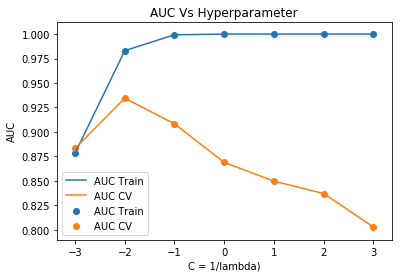

In [22]:
#BOW
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(base_x_train)
x_test = count_vect.transform(base_x_test)
x_cv = count_vect.transform(base_x_cv)

#Standardize the data
scalar = StandardScaler(with_mean= False)
x_train = scalar.fit_transform(x_train)
x_cv = scalar.transform(x_cv)
x_test = scalar.transform(x_test)

C = [10**-3,10**-2,10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l1',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()

# print('optimal lambda (Max AUC) is : ',optimal_c)


#### Testing with Test data

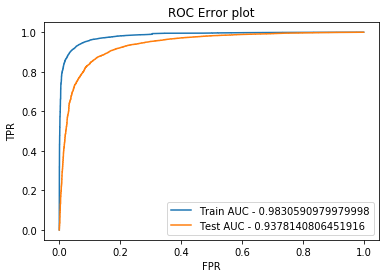

In [23]:
model = LogisticRegression(penalty= 'l1',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


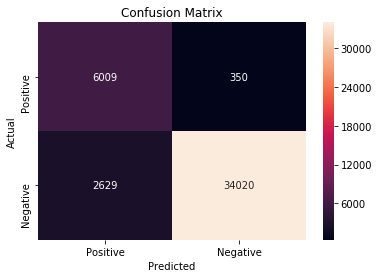

Confusion Matrix for train data


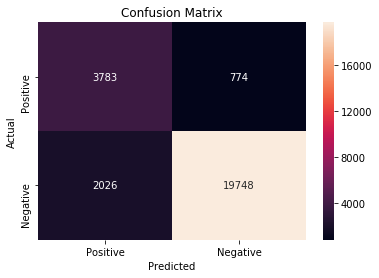

In [24]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [25]:
lr = LogisticRegression(penalty='l1',class_weight = 'balanced',C = optimal_c)
lr.fit(x_train,y_train)
weight = lr.coef_
#Sparsity of vector weight=no of zero in weight vector
print('Number of non zero element in weight vector ',np.count_nonzero(weight))

Number of non zero element in weight vector  3494


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


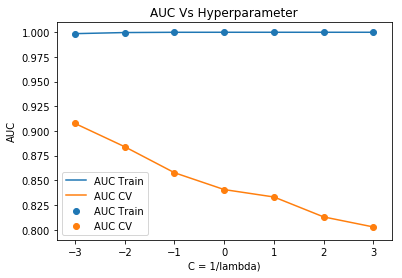

In [26]:
#BOW
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(base_x_train)
x_test = count_vect.transform(base_x_test)
x_cv = count_vect.transform(base_x_cv)

#Standardize the data
scalar = StandardScaler(with_mean= False)
x_train = scalar.fit_transform(x_train)
x_cv = scalar.transform(x_cv)
x_test = scalar.transform(x_test)


C = [10**-3, 10**-2, 10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l2',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()

# print('optimal lambda (Max AUC) is : ',optimal_c)


#### Testing with Test data

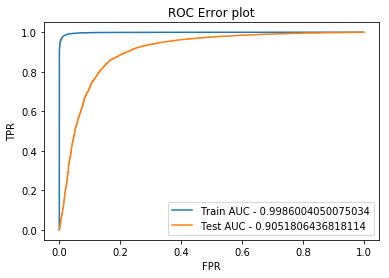

In [27]:
model = LogisticRegression(penalty= 'l2',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


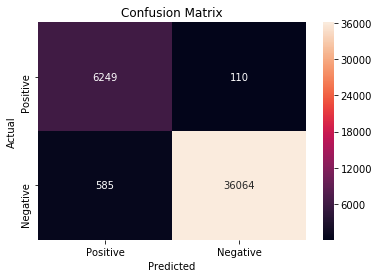

Confusion Matrix for train data


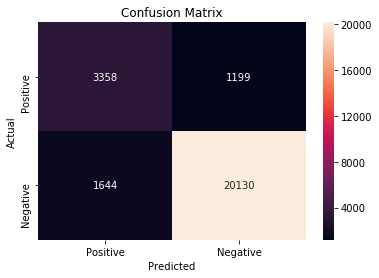

In [28]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

#### Find with weight vector using train without noise

In [29]:
clf_before = LogisticRegression(C= 1, penalty= 'l2')
clf_before.fit(x_train,y_train)
w_after= clf_before.coef_
x_train.data+=0.001  #this is used for adding noise to data. If you are getting typecase error, use numpy add with casting set to 'unsafe'

In [30]:
clf_after = LogisticRegression(C= 1, penalty= 'l2')
clf_after.fit(x_train,y_train)
w_before= clf_after.coef_

#### Find with weight vector using train with noise

In [31]:
diff = w_after - w_before
print("Average difference in weight vectors: ",np.mean(diff))

Average difference in weight vectors:  -6.955799258467983e-05


Obeservation - Differences in the coefficients of the peturbed model and original model are very less so weight vector of the classifier can be considered for the feature importance

In [ ]:
# lr = LogisticRegression(penalty= 'l2',class_weight = 'balanced',C = 1)
# lr.fit(x_train,y_train)
# w_before = lr.coef_

In [ ]:
# epsilon = np.random.normal(loc = 0, scale = 0.0000001,size = x_train.shape)
# X_e.data=X_e.data+np.random.normal(loc=0,scale=0.0001,size=X_e.data.shape)
# x_train_epsilon = x_train + epsilon

# x_train_epsilon = x_train + np.random.normal(loc = 0, scale = 0.0001,size = x_train.shape)

In [ ]:
# lr = LogisticRegression(penalty= 'l2',class_weight = 'balanced',C = 1)
# lr.fit(x_train_epsilon,y_train)
# w_after = lr.coef_

In [ ]:
# diff = w_after - w_before
# print("Average difference in weight vectors:- ",np.mean(diff))

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [34]:
lr = LogisticRegression(penalty= 'l1',class_weight = 'balanced',C = 0.001)
lr.fit(x_train,y_train)
fn = count_vect.get_feature_names()
w = list(lr.coef_[0])
# print(w)
pos_coef =[]
neg_coef = []
pos_words =[]
neg_words =[]

for i,c in enumerate(w):
    if c > 0:
        pos_coef.append(c)
        pos_words.append(fn[i]) 
    else:
        neg_coef.append(abs(c))
        neg_words.append(fn[i])

pos_df = pd.DataFrame(columns= ['words', 'coef'])
neg_df = pd.DataFrame(columns= ['words', 'coef'])
pos_df['words'] = pos_words
neg_df['words'] = neg_words
pos_df['coef'] = pos_coef
neg_df['coef'] = neg_coef


In [35]:
pos_df = pos_df.sort_values('coef',axis = 0,ascending = False).reset_index(drop = True)

print('Top 10 Important features of positive class -\n',pos_df.head(10))


Top 10 Important features of positive class -
        words      coef
0      great  0.374052
1       best  0.224588
2  delicious  0.217418
3       love  0.178129
4    perfect  0.132145
5       good  0.132019
6      loves  0.129792
7       easy  0.101703
8  excellent  0.093120
9     highly  0.087079


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [36]:
neg_df = neg_df.sort_values('coef',axis = 0,ascending = False).reset_index(drop = True)

print('Top 10 Important features of negative class -\n',neg_df.head(10))


Top 10 Important features of negative class -
            words      coef
0            not  0.262289
1   disappointed  0.125496
2          worst  0.102344
3            bad  0.088504
4          money  0.082809
5       horrible  0.081595
6          awful  0.078224
7       terrible  0.077012
8        thought  0.074323
9  unfortunately  0.067954


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


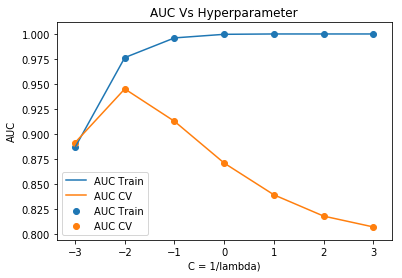

In [37]:
#BOW

tf_idf_vect = TfidfVectorizer(min_df= 10) 
x_train = tf_idf_vect.fit_transform(base_x_train)
x_test = tf_idf_vect.transform(base_x_test)
x_cv = tf_idf_vect.transform(base_x_cv)

#Standardize the data
scalar = StandardScaler(with_mean= False)
x_train = scalar.fit_transform(x_train)
x_cv = scalar.transform(x_cv)
x_test = scalar.transform(x_test)


# tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

C = [10**-3, 10**-2, 10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l1',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()

# print('optimal lambda (Max AUC) is : ',1//optimal_c)


#### Testing with Test data

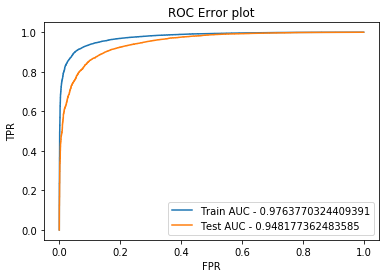

In [38]:
model = LogisticRegression(penalty= 'l1',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


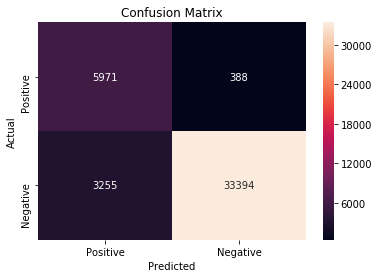

Confusion Matrix for train data


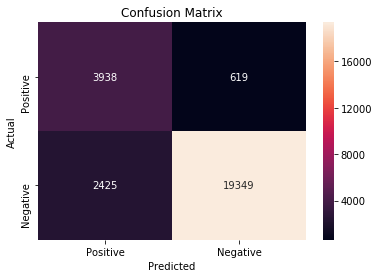

In [39]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


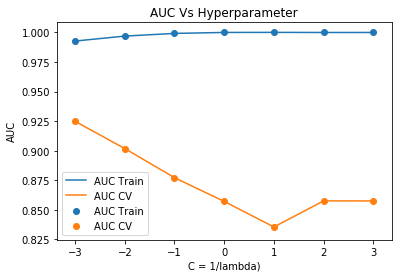

In [40]:
#BOW
tf_idf_vect = TfidfVectorizer(min_df= 10) 
x_train = tf_idf_vect.fit_transform(base_x_train)
x_test = tf_idf_vect.transform(base_x_test)
x_cv = tf_idf_vect.transform(base_x_cv)

#Standardize the data
scalar = StandardScaler(with_mean= False)
x_train = scalar.fit_transform(x_train)
x_cv = scalar.transform(x_cv)
x_test = scalar.transform(x_test)


C = [10**-3, 10**-2,10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l2',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()


#### Testing with Test data

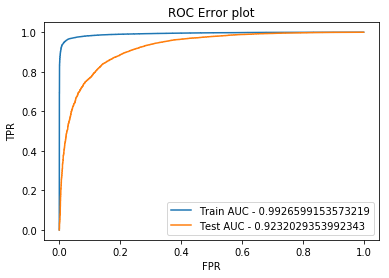

In [41]:
model = LogisticRegression(penalty= 'l2',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


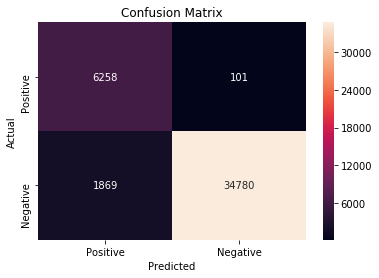

Confusion Matrix for train data


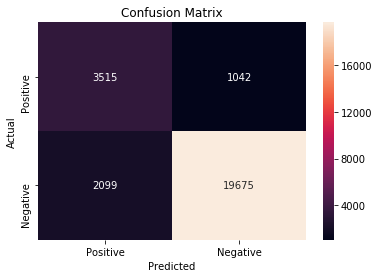

In [42]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [43]:
lr = LogisticRegression(penalty= 'l1',class_weight = 'balanced',C = optimal_c)
lr.fit(x_train,y_train) 
fn = tf_idf_vect.get_feature_names()
print((fn[1:10]))
w = list(lr.coef_[0])

print(len(w))
pos_coef =[]
neg_coef = []
pos_words =[]
neg_words =[]

for i,c in enumerate(w):
#     print('i------------',i)
#     print('c------------',c)
    if c > 0:
        pos_coef.append(c)
        pos_words.append(fn[i]) 
    else:
        neg_coef.append(abs(c))
        neg_words.append(fn[i])

pos_df = pd.DataFrame(columns= ['words', 'coef'])
neg_df = pd.DataFrame(columns= ['words', 'coef'])
pos_df['words'] = pos_words
neg_df['words'] = neg_words
pos_df['coef'] = pos_coef
neg_df['coef'] = neg_coef

pos_df = pos_df.sort_values('coef',axis = 0,ascending = False).reset_index(drop = True)

print('Top 10 Important features of positive class -\n',pos_df.head(10))


['abdominal', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absolutly', 'absorb']
8083
Top 10 Important features of positive class -
        words      coef
0      great  0.431203
1       best  0.260459
2  delicious  0.226270
3       love  0.221095
4       good  0.179635
5    perfect  0.139171
6      loves  0.137530
7       find  0.105392
8       nice  0.099771
9   favorite  0.093241


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [44]:
neg_df = neg_df.sort_values('coef',axis = 0,ascending = False).reset_index(drop = True)

print('Top 10 Important features of negative class -\n',neg_df.head(10))


Top 10 Important features of negative class -
            words      coef
0            not  0.260298
1   disappointed  0.111554
2          worst  0.099940
3            bad  0.082465
4       terrible  0.077616
5          awful  0.075832
6       horrible  0.075758
7          money  0.072739
8        thought  0.066702
9  unfortunately  0.060907


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

#### Hyper parameter Tuning using Simple for loop

### Training w2v model

In [45]:
# w2v for train

#Preparing Reviews for gensim model

list_of_sentance_train = []
for sentance in base_x_train :
    list_of_sentance_train.append(sentance.split())
    
# Training w2v model
w2v_model = Word2Vec(list_of_sentance_train , min_count = 5, size = 50, workers =4)
w2v_words = list(w2v_model.wv.vocab)
print('no of words occured min 5 times ',len(w2v_words))
print("sample words ", w2v_words[0:50])


no of words occured min 5 times  12483
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


#### Converting Train data text

In [46]:

# Converting Reviews into Numerical Vectors using W2V vectors
## Algorithm: Avg W2V

# compute average word2vec for each review.
sent_vectors = []; #the average word2vec for each sentance/review will store in this list
# for sent in tqdm(list_of_sentance_train):
for sent in (list_of_sentance_train):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec =  w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])


(43008, 50)
[ 0.0695597   0.26210574 -0.03847536  0.67813659  0.21284877  0.28683027
  0.03528085 -0.13975251  0.28017139  0.03001817 -0.35874062 -0.07485592
 -0.16230482  0.46536249  0.3186563  -0.17571915  0.14646051  0.45746915
 -0.50107873  0.59694558 -0.42665026  0.08409735 -0.34109022  0.20028363
  0.02489534 -0.03462529 -0.51735375  0.23403109 -0.26359393  0.26219283
  0.36722057  0.28272104 -0.20935628  0.2984979  -0.353033   -0.23942683
 -0.03639696 -0.15451757 -0.60611109  0.14132131  0.08259926  0.21612827
 -0.40216905 -0.12408005  0.41633012  0.40704982  0.43070303  0.11629507
  0.43682186  0.08633048]


#### Converting CV data text

In [47]:
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())

In [48]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; #the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    cnt_words = 0 
    for word in sent: #for each word in a review/sentance
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])


(18432, 50)
[-6.12690673e-02  3.58439661e-01  4.19460560e-02  1.06436857e+00
 -8.50755068e-02  2.90837769e-01  1.43359740e-01 -8.00742883e-01
  1.82480054e-01  1.10252766e-01  2.39786868e-01 -7.74416390e-03
  3.20715215e-01  3.70796418e-01  6.15053054e-01 -3.46767233e-01
  6.19271110e-01  3.28763154e-01 -9.80163909e-02  6.01097659e-01
  5.01815096e-01  2.01231253e-01 -4.62018127e-01 -5.28082929e-04
  1.63194770e-01 -9.94588276e-02 -7.13610587e-01  1.36658230e+00
 -8.12460679e-01  2.59664413e-02  6.92482793e-01  4.73151750e-01
 -1.33049624e-02 -6.72545285e-02 -3.82696081e-01  1.11811500e-02
  1.48109242e-01  3.67342281e-01  1.93507934e-02  6.77744817e-01
  2.22311611e-01  1.93007939e-01 -3.26650926e-01 -3.19799387e-01
  4.11689929e-01  9.04277051e-01  7.30048991e-01  7.54266588e-01
  1.85454310e-01  5.72548671e-01]


#### Testing with Test data

In [49]:
list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())

In [50]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; #the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):

    sent_vec = np.zeros(50)
    cnt_words = 0 
    for word in sent: #for each word in a review/sentance
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])


(26331, 50)
[-0.05361983  0.36880882 -0.30382451  0.62871976  0.3642346   0.28036152
 -0.19573003 -0.19000585  0.36496428 -0.07103195 -0.55244673 -0.55848462
 -0.044952   -0.37856722 -0.05389363 -0.22664909  0.56048387 -0.54759742
 -0.3410366   1.20927062 -0.44833872  0.42739542  0.59842996  0.12787154
 -0.43191077  0.48266059 -0.55542726  0.20326464 -0.22385902  0.91305132
  0.11341208 -0.06216123 -0.37716007  0.31175344  0.00681467 -0.03707754
 -0.67906578 -0.0571281  -0.6105633   0.00714729 -0.56677026  0.45751253
 -0.1922163  -0.53992651  0.30422274 -0.25737675  0.36423105  0.19714763
  0.11119163  0.66526588]


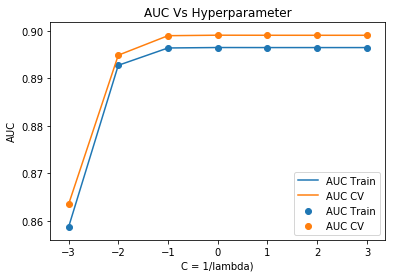

In [51]:
x_train = sent_vectors_train
x_cv = sent_vectors_cv
x_test = sent_vectors_test

C = [10**-3, 10**-2, 10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l1',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()

# print('optimal lambda (Max AUC) is : ',1//optimal_c)


#### Testing with Test data

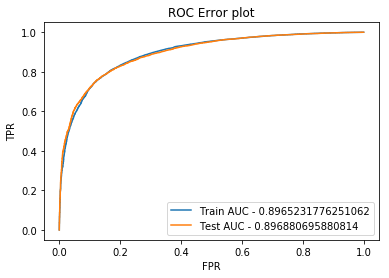

In [52]:
model = LogisticRegression(penalty= 'l1',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


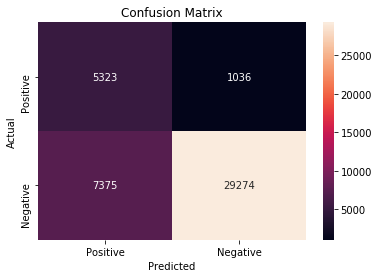

Confusion Matrix for train data


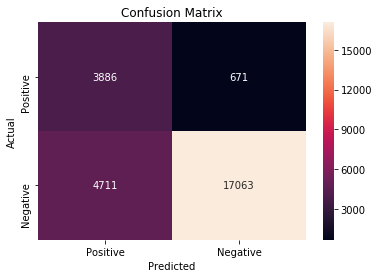

In [53]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

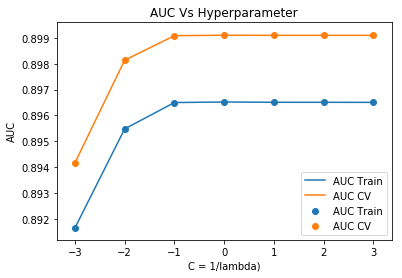

In [55]:
#BOW

C = [10**-3, 10**-2, 10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l2',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()

# print('optimal lambda (Max AUC) is : ',1//optimal_c)


#### Testing with Test data

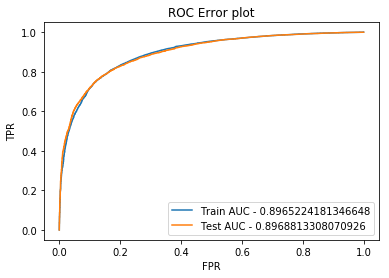

In [56]:
model = LogisticRegression(penalty= 'l2',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


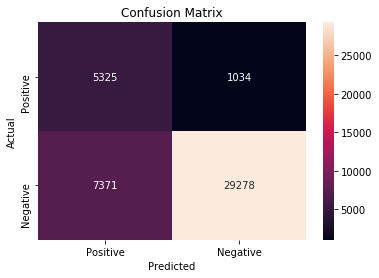

Confusion Matrix for train data


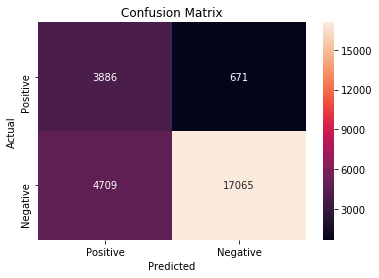

In [57]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

#### Hyper parameter Tuning using Simple for loop

### Training w2v model

In [59]:
# w2v for train
# Preparing Reviews for gensim model

list_of_sentance_train = []
for sentance in base_x_train:
    list_of_sentance_train.append(sentance.split())

w2v_model = Word2Vec(list_of_sentance_train , min_count = 5 ,size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

In [1]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df= 10,max_features= 500)

tf_idf_matrix = tf_idf_vect.fit_transform(base_x_train)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))


NameError: name 'TfidfVectorizer' is not defined

#### Converting Train data text

In [61]:

tfidf_sent_vectors_train = []
row = 0

# for sent in tqdm(list_of_sentance_train):
for sent in (list_of_sentance_train):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#### Converting CV data


In [62]:
list_of_sentance_cv = []
for sentance in base_x_cv:
    list_of_sentance_cv.append(sentance.split())
    
tfidf_sent_vectors_cv = []
row = 0

# for sent in tqdm(list_of_sentance_cv):
for sent in (list_of_sentance_cv):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#### Converting test data


In [63]:
list_of_sentance_test = []
for sentance in base_x_test:
    list_of_sentance_test.append(sentance.split())
    
tfidf_sent_vectors_test = []
row = 0

# for sent in tqdm(list_of_sentance_test):
for sent in (list_of_sentance_test):
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum = tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

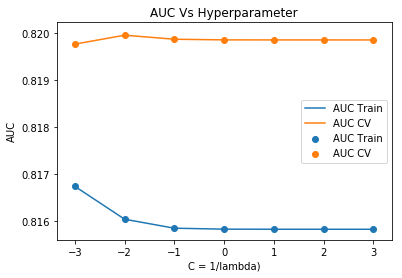

In [64]:
x_train = tfidf_sent_vectors_train
x_cv = tfidf_sent_vectors_cv
x_test = tfidf_sent_vectors_test

C = [10**-3, 10**-2, 10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l1',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()

# print('optimal lambda (Max AUC) is : ',1//optimal_c)


#### Testing with Test data

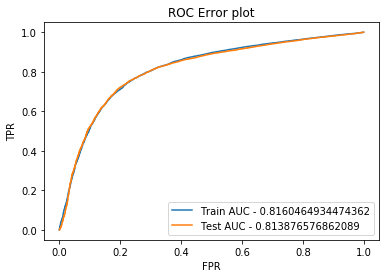

In [65]:
model = LogisticRegression(penalty= 'l1',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


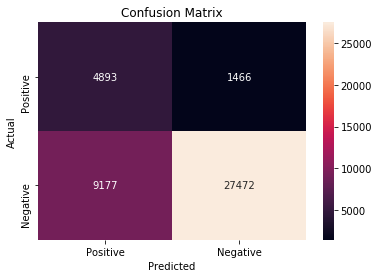

Confusion Matrix for train data


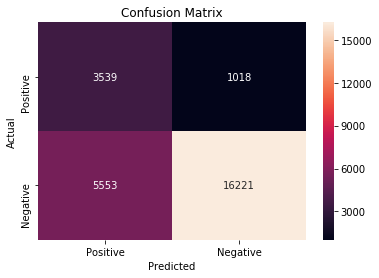

In [66]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

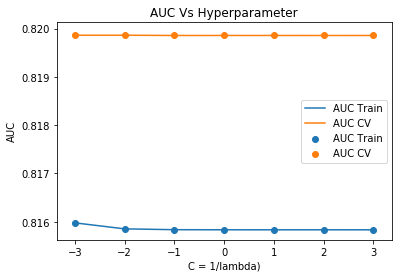

In [68]:
#BOW

C = [10**-3, 10**-2, 10**-1,10**0,10**1, 10**2, 10**3] #C = 1/lambda
auc_train = []
auc_cv = []

for i in C :
    model = LogisticRegression(penalty='l2',class_weight = 'balanced',C = i)
    model.fit(x_train,y_train)
    
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_cv_prob =  model.predict_proba(x_cv)[:,1]
    
    auc_train.append(roc_auc_score(y_train,y_train_prob))
    auc_cv.append(roc_auc_score(y_cv, y_cv_prob))
    

optimal_c = C[auc_cv.index(max(auc_cv))]
C = [np.log10(x) for x in C]

fig = plt.figure()

plt.plot(C, auc_train, label='AUC Train')
plt.scatter(C, auc_train, label='AUC Train')
plt.plot(C,auc_cv,label = 'AUC CV')
plt.scatter(C,auc_cv,label = 'AUC CV')

plt.title('AUC Vs Hyperparameter')
plt.xlabel('C = 1/lambda)')
plt.ylabel('AUC')
plt.legend()
plt.show()

# print('optimal lambda (Max AUC) is : ',1//optimal_c)


#### Testing with Test data

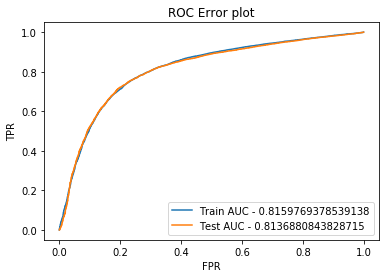

In [69]:
model = LogisticRegression(penalty= 'l2',class_weight = 'balanced',C = optimal_c)
model.fit(x_train,y_train)

train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]

train_fpr,train_tpr,thresholds1 = metrics.roc_curve(y_train,train_prob)
test_fpr,test_tpr,thresholds2 = metrics.roc_curve(y_test,test_prob)

plt.plot(train_fpr,train_tpr, label = "Train AUC - " + str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr, label = 'Test AUC - ' + str(auc(test_fpr,test_tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Error plot')
plt.legend()
plt.show()


#### Confusion Matrix using Heatmap

Confusion Matrix for train data


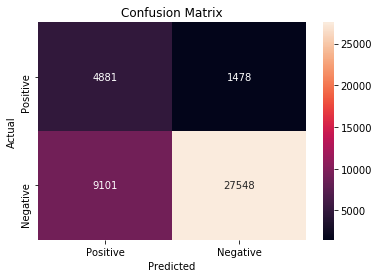

Confusion Matrix for train data


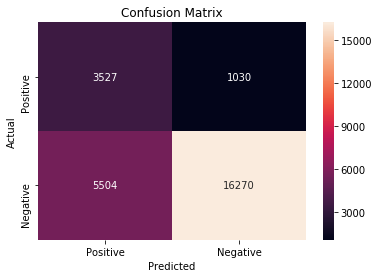

In [70]:
#confusion matrix using heatmap for train data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_train, model.predict(x_train))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix using heatmap for test data
print('Confusion Matrix for train data')
cm = confusion_matrix(y_test, model.predict(x_test))
class_labels = ['Positive', 'Negative']
df = pd.DataFrame(cm, index = class_labels, columns= class_labels)
sb.heatmap(df, annot= True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# [6] Conclusions

In [74]:
# compare all your models 
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Regularization", "Hyperameter(lambda)", "AUC"]
x.add_row(["BOW","l1",0.01,0.93])
x.add_row(["BOW","l2",0.001,0.90])
x.add_row(["TFIDF","l1",0.01,0.94])
x.add_row(["TFIDF","l2",0.001,0.94])
x.add_row(["AVG W2v","l1",1,0.89])
x.add_row(["AVG W2v","l2",1,0.89])
x.add_row(["TFIDF W2v","l1",0.001,0.81])
x.add_row(["TFIDF W2v","l2",0.001,0.81])
print(x)

+------------+----------------+---------------------+------+
| Vectorizer | Regularization | Hyperameter(lambda) | AUC  |
+------------+----------------+---------------------+------+
|    BOW     |       l1       |         0.01        | 0.93 |
|    BOW     |       l2       |        0.001        | 0.9  |
|   TFIDF    |       l1       |         0.01        | 0.94 |
|   TFIDF    |       l2       |        0.001        | 0.94 |
|  AVG W2v   |       l1       |          1          | 0.89 |
|  AVG W2v   |       l2       |          1          | 0.89 |
| TFIDF W2v  |       l1       |        0.001        | 0.81 |
| TFIDF W2v  |       l2       |        0.001        | 0.81 |
+------------+----------------+---------------------+------+
